# Capstone Project: Predicting Speeding from Open Street Maps and Telematics Data

##### Professional Certificate in Machine Learning and Artificial Intelligence
##### Jeremy Stairs
##### June 2024

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time    

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## 1. Business Understanding

### Executive Summary

This project uses Open Street Maps (OSM) data with fleet vehicle data to predict if a driver is speeding in each driving report. Using OSM data, the cost per report will be much lower than the paid mapping services. Unfortunately, OSM is far from complete. Many requests are returned with no speed limit. It's difficult to predict the speed limit in a specific location using just OSM data. However, we might be able to use OSM data along with the known vehicle speed to predict if the driver is speeding. It's unlikelt that the error will be low enough to reliably send an alert to the user. Still, this prediction can idicate potential speeding. If speeding is likely, we can perform more accurate and costly speed limit queries. Ultimately, it's important that we catch each instance of speeding to ensure driver safety for all of our customers.

### Rationale

As a fleet telematics company, our customers reqire alerts when drivers are speeding. Vehicle speed is included in each vehicle report. However, there are few complete speed limit databases. None are free. The Open Street Map project includes speed limits, but this only covers about 12% of its roads. Until the crowd-sourced database is complete, a model for predicting when a driver is speeding would allow us to reduce costs while still providing our customers with alerts needed to ensure fleet vehicles are driven safely. 

### Research Question

Can telematics data and Open Street maps data be used to determine if a driver is speeding?

Note:
My original question asked if the speed limit could be predicted from OSM data. Early testing showed scores under 0.3. This was likely due to the target being multilabel with over 10 different labels. I decided to refoucus the question to determine when vehicles were driven over the posted speed limit. Thas has a simiple yes/no target and is very relavent to our company's speed limit alert serivce.

## 2. Data Understanding

### Data Sources

This project has two data sources:

- Fleet telematics data
- Open Street Maps (OSM) tag data

Speed limits and associated mapping data are publicly available from the Open Street Map (OSM) project. There are mapping files with varying levels of granularity (continent, country, state). The files can be uncompressed and imported to a PostgreSQL server. The compressed mapping files for the entire world are about 100 GB which require about 1TB of database space. We have a server with full mapping data for the continental US. 

OSM Wiki: https://wiki.openstreetmap.orgLinks to an external site.

OSM mapping files: https://download.geofabrik.de/

Our units in the field report telematics data periodically while moving. This data is combined with data from OSM based on the vehicle location. I extracted data for several days of reporting when both vehicle speed and OSM speed limit were included. The data was unaltered expect for the 'speeding' column which was derived from the posted speed limit and the vehicle speed.

In [2]:
speeding = pd.read_csv('data/speeding.csv', low_memory=False)

In [3]:
speeding.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196472 entries, 0 to 196471
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   normalizedSpeed  196430 non-null  float64
 1   lanes            184500 non-null  object 
 2   oneway           170363 non-null  object 
 3   surface          121077 non-null  object 
 4   hgv              105231 non-null  object 
 5   foot             55820 non-null   object 
 6   horse            34329 non-null   object 
 7   bicycle          90839 non-null   object 
 8   speeding         196472 non-null  object 
dtypes: float64(1), object(8)
memory usage: 13.5+ MB


The dataset contains eight features and one target:
- normalizedSpeed - vehicle speed normalized to miles per hour
- lanes - number of lanes traveling in the same direction
- oneway - indicates if the OSM way only allows travel in one directions, possible values: yes, no, reversible, alternating
- surface - the phyical surface of the OSM way
- hgv - indicates conditions for heavy good vehicles
- foot - indicates if pedestrian foot traffic is allowed
- horse - indicates if equestrians are allowed
- bicycle - indicates if bicyclists are allowed
- speeding - target - if 'yes', the vehicle speed was greater than posted speed limit, otherwise 'no'

## 3. Data Perparation

In [4]:
speeding.head(10)

,normalizedSpeed,lanes,oneway,surface,hgv,foot,horse,bicycle,speeding
0,61.0,2,NaN,asphalt,NaN,NaN,NaN,NaN,Yes
1,16.0,2,NaN,asphalt,NaN,NaN,NaN,NaN,No
2,50.0,3,yes,NaN,designated,no,no,no,No
3,19.0,2,NaN,asphalt,NaN,NaN,NaN,NaN,No
4,0.0,2,yes,asphalt,NaN,NaN,NaN,NaN,No
5,0.0,2,no,asphalt,NaN,NaN,NaN,NaN,No
6,5.0,2,no,asphalt,NaN,NaN,NaN,NaN,No
7,66.0,4,yes,NaN,designated,no,no,no,Yes
8,56.0,3,yes,NaN,designated,no,no,no,No
9,23.0,3,yes,NaN,designated,no,no,no,No


OSM tags are sparsly populated. Unfortunately, this means that the dataset has many NaN vlaues. Before analysis, records with null values and duplicate records are removed.

In [5]:
speeding.dropna(inplace=True)
print('Row count after null values have been removed: ', speeding.shape[0])

Row count after null values have been removed:  17662


Many vheicles travel on regular routes or perform work in a limited territory. The dataset originally had a large number of duplicates. These were previously removed to reduce the file size.

Reset the dataframe index

In [6]:
speeding.reset_index(drop=True)

,normalizedSpeed,lanes,oneway,surface,hgv,foot,horse,bicycle,speeding
0,63.000000,3,yes,asphalt,designated,no,no,no,Yes
1,45.000000,2,yes,asphalt,designated,no,no,no,No
2,32.000000,3,yes,asphalt,designated,no,no,no,No
3,40.000000,3,yes,asphalt,designated,no,no,no,No
4,47.000000,3,yes,asphalt,designated,no,no,no,Yes
...,...,...,...,...,...,...,...,...,...
17657,9.000000,3,yes,concrete,designated,no,no,yes,No
17658,23.245489,5,yes,asphalt,designated,no,no,no,No
17659,27.000000,1,yes,asphalt,designated,no,no,no,Yes
17660,69.737089,4,yes,concrete,designated,no,no,no,No


In [7]:
speeding.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17662 entries, 53 to 196462
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   normalizedSpeed  17662 non-null  float64
 1   lanes            17662 non-null  object 
 2   oneway           17662 non-null  object 
 3   surface          17662 non-null  object 
 4   hgv              17662 non-null  object 
 5   foot             17662 non-null  object 
 6   horse            17662 non-null  object 
 7   bicycle          17662 non-null  object 
 8   speeding         17662 non-null  object 
dtypes: float64(1), object(8)
memory usage: 1.3+ MB


### Feature examination

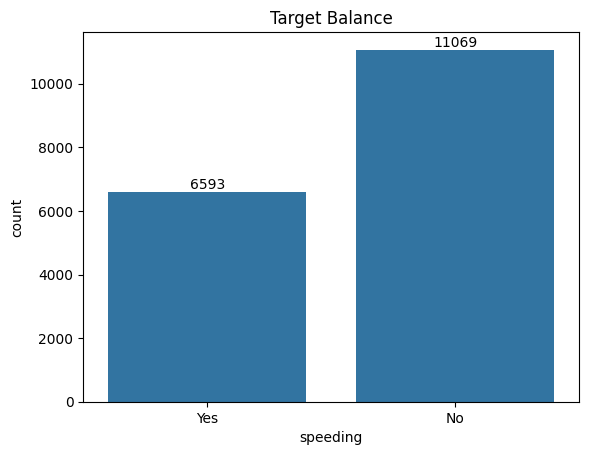

In [8]:
ax = sns.countplot(speeding, x='speeding')
ax.set_title('Target Balance')
ax.bar_label(ax.containers[0])
ax.figure.savefig("images/target_balance.png", bbox_inches='tight');

The target is imbalanced with a ratio of nearly 2 to 1 favoring 'No'.

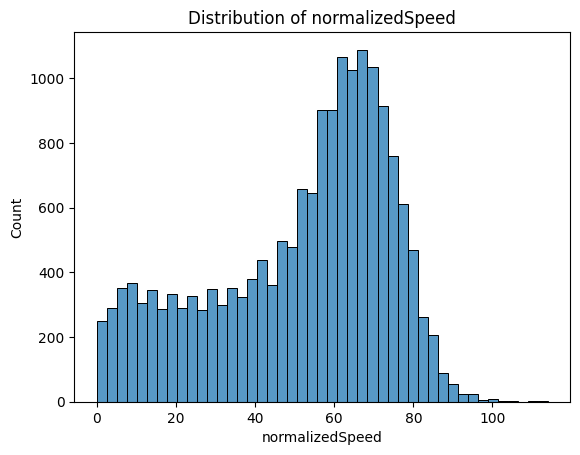

In [9]:
sns.histplot(data=speeding, x='normalizedSpeed').set_title('Distribution of normalizedSpeed');

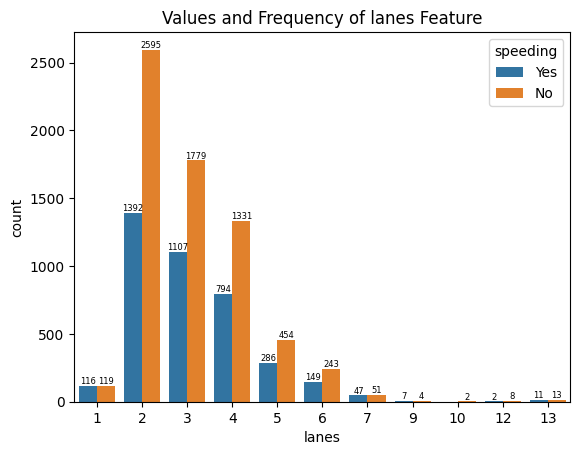

In [10]:
ax = sns.countplot(speeding, x="lanes", hue='speeding', order=sorted(speeding['lanes'].astype('float').astype('int').unique().tolist(), key=int))
ax.set_title('Values and Frequency of lanes Feature')
ax.bar_label(ax.containers[0], fontsize=6)
ax.bar_label(ax.containers[1], fontsize=6);

The feature 'lanes' appears to contain meaningful information. Some labels show an imbalence similar to the target, but the balance between 'yes' and 'no' gets more even for roads with more lanes. This could be due to a tendancy to speed on wider roads with more opportunity to safely pass.

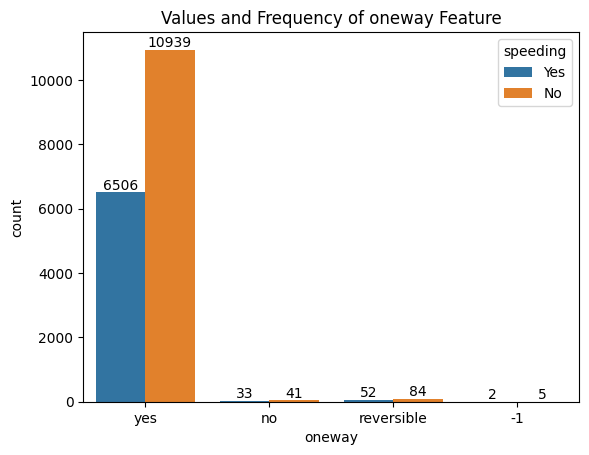

In [11]:
ax = sns.countplot(speeding, x="oneway", hue='speeding')
ax.set_title('Values and Frequency of oneway Feature')
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1]);

The value '-1' is equivalent to 'reversible'. The records with oneway='-1' will be converted to oneway='reversible'.

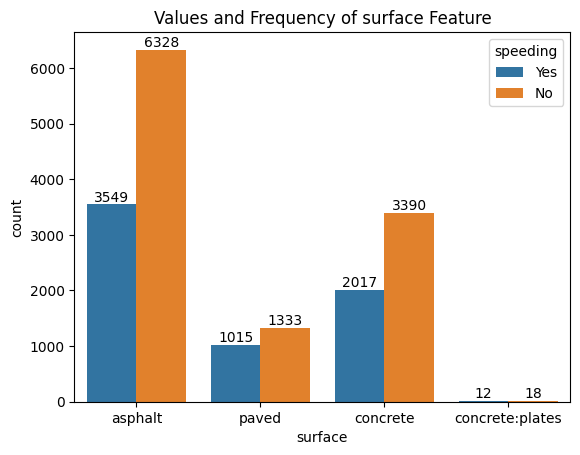

In [12]:
ax = sns.countplot(speeding, x="surface", hue='speeding')
ax.set_title('Values and Frequency of surface Feature')
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1]);

The feature 'surface' shows a tendancy to speed on paved and concrete roads.

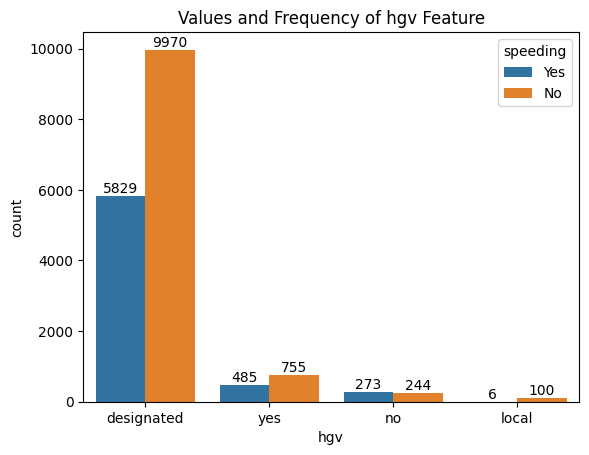

In [13]:
ax = sns.countplot(speeding, x="hgv", hue='speeding')
ax.set_title('Values and Frequency of hgv Feature')
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1]);

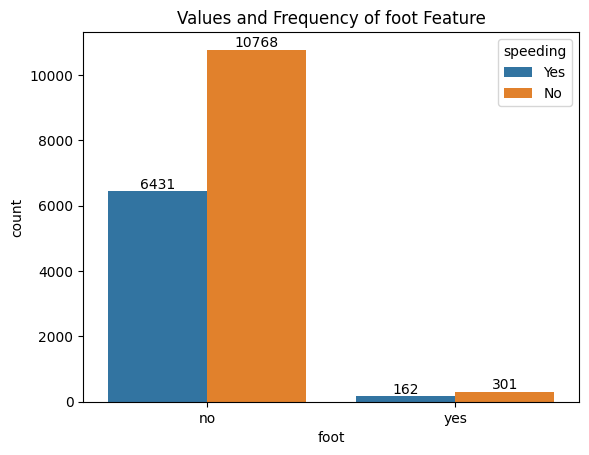

In [14]:
ax = sns.countplot(speeding, x="foot", hue='speeding')
ax.set_title('Values and Frequency of foot Feature')
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1]);

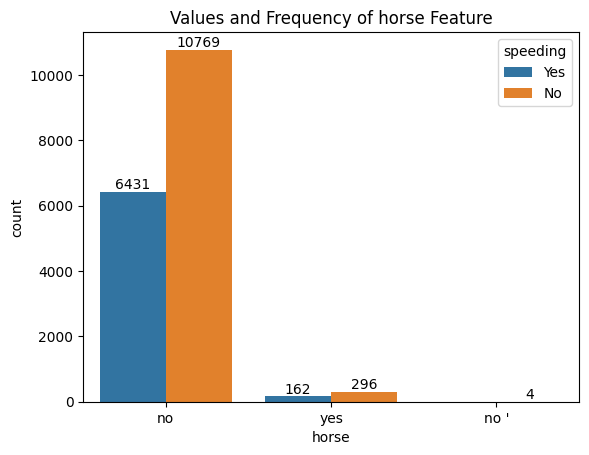

In [15]:
ax = sns.countplot(speeding, x="horse", hue='speeding')
ax.set_title('Values and Frequency of horse Feature')
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1]);

The value 'no '' is likely a typo. It will be converted to 'no'.

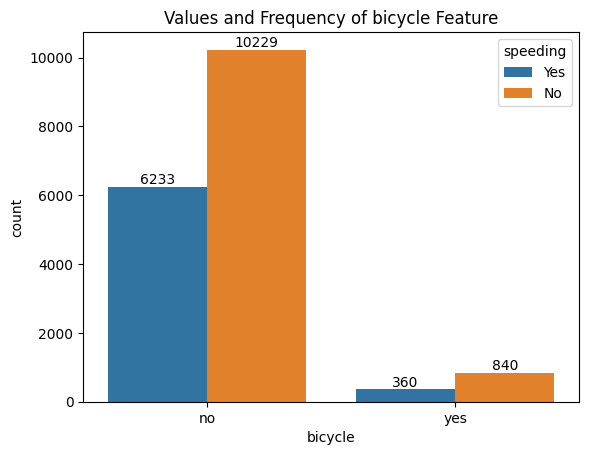

In [16]:
ax = sns.countplot(speeding, x="bicycle", hue='speeding')
ax.set_title('Values and Frequency of bicycle Feature')
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1]);

The features 'foot', 'horse', and 'bicycle' are all yes/no features which are all imbalanced favoring 'no'. However, the target balance for each feature show that they could contain meaningful informations as a group.

Data preparation:
- 'lanes' will be cast from an object to a numerical feature
- 'oneway' will have the values '-1' changed to 'reversible'
- 'horse' will have the value 'no '' converted to 'no'
- the features 'oneway', 'surface', and 'hgv' will be converted to numerical features using one-hot encoding
- the features 'foot', 'horse', and 'bicycle' will be converted to numerical features using binary encoding

### Data Cleaning

Convert the 'lanes' feature to numeric

In [17]:
speeding['lanes'] = speeding['lanes'].astype('float').astype('int32')

Remove odd values from the features 'oneway' and 'horse'

In [18]:
speeding.loc[speeding['oneway'] == '-1', 'oneway'] = 'reversible'

In [19]:
speeding.loc[speeding['horse'] == "no '", 'horse'] = 'no'

Change the fields 'surface', 'hgv', and 'oneway' to numberical fields using one hot encoding

In [20]:
speeding = pd.get_dummies(speeding, columns = ['surface', 'hgv', 'oneway'], dtype=int)

Change the fields 'foot', 'horse', and 'bicycle' to numberical fields using binary values

In [21]:
speeding['foot'] = pd.Series(np.where(speeding.foot.values == 'yes', 1, 0), speeding.index)

In [22]:
speeding['horse'] = pd.Series(np.where(speeding.horse.values == 'yes', 1, 0), speeding.index)

In [23]:
speeding['bicycle'] = pd.Series(np.where(speeding.bicycle.values == 'yes', 1, 0), speeding.index)

In [24]:
speeding.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17662 entries, 53 to 196462
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   normalizedSpeed          17662 non-null  float64
 1   lanes                    17662 non-null  int32  
 2   foot                     17662 non-null  int32  
 3   horse                    17662 non-null  int32  
 4   bicycle                  17662 non-null  int32  
 5   speeding                 17662 non-null  object 
 6   surface_asphalt          17662 non-null  int32  
 7   surface_concrete         17662 non-null  int32  
 8   surface_concrete:plates  17662 non-null  int32  
 9   surface_paved            17662 non-null  int32  
 10  hgv_designated           17662 non-null  int32  
 11  hgv_local                17662 non-null  int32  
 12  hgv_no                   17662 non-null  int32  
 13  hgv_yes                  17662 non-null  int32  
 14  oneway_no                

#### Separating the target and features

In [25]:
y = speeding['speeding']
X = speeding.drop('speeding', axis=1)

#### Spliting the data into training and test sets

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

## 4. Data Modeling

### Methodology

This project will compare four classifiers:
- Logistic Regression
- K-Nearest Neighbors
- Decision Tree
- Support Vecor Machine

A baseline will be set using DummyClassifier and LogisticRegression with default settings. Further modeling will use the classifiers above with default parameters. Light hyperparameter tuning will be done using grid search. 
Future work will include more thorough hyper parameter tuning with different scoring metrics.

#### Establish baseline scores

Using DummyClassifier

In [27]:
dummy_start_time_ms = round(time.time() * 1000)
dummy_clf = DummyClassifier(random_state=42).fit(X_train, y_train)
dummy_end_time_ms = round(time.time() * 1000)

In [28]:
baseline_train_time = dummy_end_time_ms - dummy_start_time_ms
baseline_train_score = dummy_clf.score(X_train, y_train)
baseline_test_score = dummy_clf.score(X_test, y_test)

Using LogisticRegression

In [29]:
simple_lgr_start_time_ms = round(time.time() * 1000)
simple_lgr_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('lgr', LogisticRegression(random_state=42))]).fit(X_train, y_train)
simple_lgr_end_time_ms = round(time.time() * 1000)

In [30]:
simple_lgr_train_time = simple_lgr_end_time_ms - simple_lgr_start_time_ms
simple_lgr_train_score = simple_lgr_pipe.score(X_train, y_train)
simple_lgr_test_score = simple_lgr_pipe.score(X_test, y_test)

Basline scores

In [31]:
print('Basline Classifier: Train Time is', baseline_train_time, 'ms,', \
      'Train Accuracy is', round(baseline_train_score, 4), ',', \
      'Test Accuracy is', round(baseline_test_score, 4))

Basline Classifier: Train Time is 4 ms, Train Accuracy is 0.6218 , Test Accuracy is 0.6415


In [32]:
print('Simple Model: Train Time is', simple_lgr_train_time, 'ms,', \
      'Train Accuracy is', round(simple_lgr_train_score, 4), ',', \
      'Test Accuracy is', round(simple_lgr_test_score, 4))

Simple Model: Train Time is 31 ms, Train Accuracy is 0.7814 , Test Accuracy is 0.7867


#### Support functions to get and score metrics

In [33]:
def getMetrics(model, start_time_ms, end_time_ms):
    train_time = round(end_time_ms - start_time_ms)
    train_score = round(model.score(X_train, y_train), 4)
    test_score = round(model.score(X_test, y_test), 4)
    return [train_time, train_score, test_score]

In [34]:
def printMetrics(train_time, train_score, test_score):
    print('Train Time is', train_time, 'ms,', \
      'Train Accuracy is', train_score, ',', \
      'Test Accuracy is', test_score)

#### Modeling with default values

Logistic Regression

In [35]:
lgr_start_time_ms = round(time.time() * 1000) 
default_lgr = LogisticRegression(random_state=42, max_iter=1000).fit(X_train, y_train)
lgr_end_time_ms = round(time.time() * 1000)

In [36]:
default_lgr_metrics = getMetrics(default_lgr, lgr_start_time_ms, lgr_end_time_ms)
print('Logistic Regression:')
printMetrics(*default_lgr_metrics)

Logistic Regression:
Train Time is 579 ms, Train Accuracy is 0.7817 , Test Accuracy is 0.7858


K-Nearest Neighbor

In [37]:
knn_start_time_ms = round(time.time() * 1000) 
default_knn = KNeighborsClassifier().fit(X_train, y_train)
knn_end_time_ms = round(time.time() * 1000)

In [38]:
default_knn_metrics = getMetrics(default_knn, knn_start_time_ms, knn_end_time_ms)
print('K-Neighbors:')
printMetrics(*default_knn_metrics)

K-Neighbors:
Train Time is 10 ms, Train Accuracy is 0.8376 , Test Accuracy is 0.7525


Decision Tree

In [39]:
dtc_start_time_ms = round(time.time() * 1000) 
default_dtc = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)
dtc_end_time_ms = round(time.time() * 1000)

In [40]:
default_dtc_metrics = getMetrics(default_dtc, dtc_start_time_ms, dtc_end_time_ms)
print('Decision Tree: Train Time is')
printMetrics(*default_dtc_metrics)

Decision Tree: Train Time is
Train Time is 33 ms, Train Accuracy is 0.8658 , Test Accuracy is 0.7043


Support Vector Classifier

In [41]:
svc_start_time_ms = round(time.time() * 1000) 
default_svc = SVC(random_state=42).fit(X_train, y_train)
svc_end_time_ms = round(time.time() * 1000)

In [42]:
default_svc_metrics = getMetrics(default_svc, svc_start_time_ms, svc_end_time_ms)
print('Support Vector Machine:')
printMetrics(*default_svc_metrics)

Support Vector Machine:
Train Time is 3990 ms, Train Accuracy is 0.7812 , Test Accuracy is 0.7899


Default Model Results

In [43]:
metric_columns = ['Train Time (ms)', 'Train Accuracy', 'Test Accuracy']
default_results = pd.DataFrame({ 
        'Logistic Regression': pd.Series(default_lgr_metrics, index=metric_columns), 
        'K-Nearest Neighbors': pd.Series(default_knn_metrics, index=metric_columns), 
        'Decision Tree': pd.Series(default_dtc_metrics, index=metric_columns),
        'Support Vector Machine': pd.Series(default_svc_metrics, index=metric_columns)}).T
default_results

,Train Time (ms),Train Accuracy,Test Accuracy
Logistic Regression,579.0,0.7817,0.7858
K-Nearest Neighbors,10.0,0.8376,0.7525
Decision Tree,33.0,0.8658,0.7043
Support Vector Machine,3990.0,0.7812,0.7899


Logistic regression and SVC had very close scores, but the train time for logistic regression was much faster.

#### Modeling with Light Grid Search

Logistic Regression

In [44]:
params = {
    'C': [0.1, 1, 10],
    'solver': ['lbfgs','newton-cholesky']    
}
tuned_lgr = GridSearchCV(LogisticRegression(random_state=42, max_iter=1000), params, cv=5, scoring='accuracy').fit(X_train, y_train)

In [45]:
print('Best parameters:')
print(tuned_lgr.best_params_)

Best parameters:
{'C': 1, 'solver': 'newton-cholesky'}


In [46]:
tuned_lgr_start_time_ms = round(time.time() * 1000) 
tuned_lgr.best_estimator_.fit(X_train, y_train)
tuned_lgr_end_time_ms = round(time.time() * 1000)

In [47]:
lgr_y_pred = tuned_lgr.predict(X_test)
tuned_lgr_train_time = round(tuned_lgr_end_time_ms - tuned_lgr_start_time_ms)
tuned_lgr_train_score = round(tuned_lgr.score(X_train, y_train), 4)
tuned_lgr_test_score = round(accuracy_score(y_test, lgr_y_pred), 4)
printMetrics(tuned_lgr_train_time, tuned_lgr_train_score, tuned_lgr_test_score)

Train Time is 36 ms, Train Accuracy is 0.7817 , Test Accuracy is 0.7862


K-Nearest Neighbor

In [48]:
params = {'n_neighbors': [1, 2, 5, 10],
           'metric': ['euclidean', 'minkowski']
}
gscv_knn = GridSearchCV(KNeighborsClassifier(), params, cv=5, scoring='accuracy').fit(X_train, y_train)

In [49]:
print('Best parameters:')
print(gscv_knn.best_params_)

Best parameters:
{'metric': 'euclidean', 'n_neighbors': 10}


In [50]:
tuned_knn_start_time_ms = round(time.time() * 1000) 
gscv_knn.best_estimator_.fit(X_train, y_train)
tuned_knn_end_time_ms = round(time.time() * 1000)

In [51]:
knn_y_pred = gscv_knn.predict(X_test)
tuned_knn_train_time = round(tuned_knn_end_time_ms - tuned_knn_start_time_ms)
tuned_knn_train_score = round(gscv_knn.score(X_train, y_train), 4)
tuned_knn_test_score = round(accuracy_score(y_test, knn_y_pred), 4)
printMetrics(tuned_knn_train_time, tuned_knn_train_score, tuned_knn_test_score)

Train Time is 12 ms, Train Accuracy is 0.8251 , Test Accuracy is 0.7769


Decision Tree

In [52]:
params =  {'criterion': ["gini", "entropy"],
    'max_depth': [5, 15, None],
    'min_samples_split': [5, 50, 200],
    'min_samples_leaf': [1, 5]
}
tuned_dtc = GridSearchCV(DecisionTreeClassifier(random_state=42), params, cv=5, scoring='accuracy').fit(X_train, y_train)

In [53]:
print(tuned_dtc.best_params_)

{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 5, 'min_samples_split': 5}


In [54]:
tuned_dtc_start_time_ms = round(time.time() * 1000) 
tuned_dtc.best_estimator_.fit(X_train, y_train)
tuned_dtc_end_time_ms = round(time.time() * 1000)

In [55]:
dtc_y_pred = tuned_dtc.predict(X_test)
tuned_dtc_train_time = round(tuned_dtc_end_time_ms - tuned_dtc_start_time_ms)
tuned_dtc_train_score = round(tuned_dtc.score(X_train, y_train), 4)
tuned_dtc_test_score = round(accuracy_score(y_test, dtc_y_pred), 4)
printMetrics(tuned_dtc_train_time, tuned_dtc_train_score, tuned_dtc_test_score)

Train Time is 21 ms, Train Accuracy is 0.798 , Test Accuracy is 0.8034


Support Vector Classifier

In [56]:
params = {
    'C': [1, 10],
    'kernel': ['rbf','poly']    
}
gscv_svc = GridSearchCV(SVC(random_state=42), params, return_train_score=True, cv=5, scoring='accuracy').fit(X_train, y_train)

In [57]:
print(gscv_svc.best_params_)

{'C': 10, 'kernel': 'rbf'}


In [58]:
tuned_svc_start_time_ms = round(time.time() * 1000) 
gscv_svc.best_estimator_.fit(X_train, y_train)
tuned_svc_end_time_ms = round(time.time() * 1000)

In [59]:
svc_y_pred = gscv_svc.predict(X_test)
tuned_svc_train_time = round(tuned_svc_end_time_ms - tuned_svc_start_time_ms)
tuned_svc_train_score = round(gscv_svc.score(X_train, y_train), 4)
tuned_svc_test_score = round(accuracy_score(y_test, svc_y_pred), 4)
printMetrics(tuned_svc_train_time, tuned_svc_train_score, tuned_svc_test_score)

Train Time is 3955 ms, Train Accuracy is 0.7827 , Test Accuracy is 0.7903


Light Hyperparameter Tuning Results

In [60]:
tuned_results = pd.DataFrame({
    'Train Time (ms)': [tuned_lgr_train_time, tuned_knn_train_time, tuned_dtc_train_time, tuned_svc_train_time],
    'Train Accuracy': [tuned_lgr_train_score, tuned_knn_train_score, tuned_dtc_train_score, tuned_svc_train_score],
    'Test Accuracy': [tuned_lgr_test_score, tuned_knn_test_score, tuned_dtc_test_score, tuned_svc_test_score]
}, index=['Logistic Regression','K-Nearest Neighbors','Decision Tree','Support Vector Machine'])
tuned_results

,Train Time (ms),Train Accuracy,Test Accuracy
Logistic Regression,36,0.7817,0.7862
K-Nearest Neighbors,12,0.8251,0.7769
Decision Tree,21,0.7980,0.8034
Support Vector Machine,3955,0.7827,0.7903


With light hyperparameter tuning, the decision tree model had the best score. The training score is much lower indicating that the DTC training with default parameters led to overfitting.

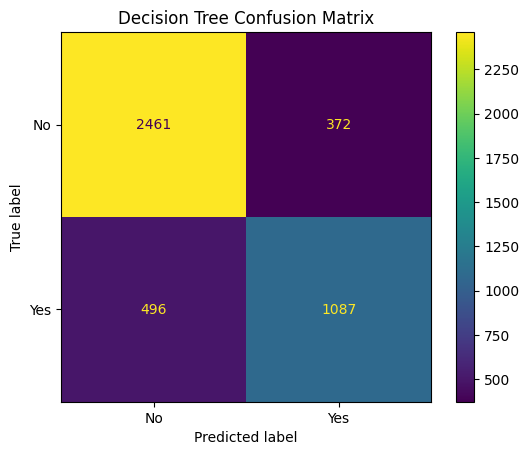

In [61]:
dtc_cm = confusion_matrix(y_test, dtc_y_pred)

dtc_cmd = ConfusionMatrixDisplay(confusion_matrix=dtc_cm, display_labels=tuned_dtc.classes_)
fig = dtc_cmd.plot().figure_
plt.title('Decision Tree Confusion Matrix')
plt.show()
fig.tight_layout(rect=(0,.05,1,1)) 

## 5. Model Evaluation

### Results

The baseline score with the dummy classifier was 0.6415. The score from SVC with default parameters was much better at 0.7899. With light hyperparameter tuning using grid search, the decision tree has the best score improved at 0.8034.

### Conclusion and Next Steps

The test scores show that ML modeling is a viable way to predict events where the driver is over the posted speed limit. Further imporvements to the models should increase accuracy. 

Future work will use grid search to more thoroughly tune hyperparameters. It will also consider scoring metrics to reduce false negatives or false positives for different business cases. We need to determine if the predictions should favor a lower the chance of missing a speeding event or a lower chance of sending a false speeding alert. This will be a business decision, but it will affect the scoring method used to optimize the models.